<a href="https://colab.research.google.com/github/sr6awi/ieee_fraud_detection/blob/main/notebooks/02_data_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEEE-CIS Fraud Detection — 02_data_eda.ipynb
**Phase:** Exploratory Data Analysis (EDA)  
**Owner:** Salem Ihsan Abidrabbu  


---

## 1) Dataset Overview
- Load train/test datasets  
- Show shapes & columns  
- Preview first 5 rows (`.head()`)

---

## 2) Target Variable Exploration
- Distribution of `isFraud`  
- Fraud vs Non-Fraud counts & %  
- Visualize imbalance (bar plot / pie chart)

---

## 3) Missing Values & Data Types
- Count missing values per feature  
- % missing per feature  
- Summarize categorical vs numerical features  
- Note any obvious cleaning required

---

## 4) Numerical Features
- Summary stats (`.describe()`)  
- Distribution plots (histograms, KDE)  
- Correlation heatmap with `isFraud` and between features

---

## 5) Categorical Features
- Cardinality check (# of unique values)  
- Top 10 most frequent values per categorical feature  
- Fraud rate per category (where feasible)

---

## 6) Time & Transaction Features
- Distribution of `TransactionDT` (time deltas)  
- Trends: fraud rate over time  
- Transaction amount distribution (log-scale if needed)

---

## 7) Cross-Feature Insights
- Compare key categorical features against fraud rate  
- Pairwise plots of important numerical features  
- Check for suspiciously strong correlations (potential leakage)

---

## 8) Data Quality & Leakage Checks
- Look for columns that might “leak” target info (post-transaction features, engineered IDs)  
- Validate test/train consistency in feature distributions  

---

## 9) Key Findings Summary
- Imbalance level confirmation  
- High-missing features flagged  
- Candidate strong predictors  
- Suspected leakage columns (to drop later)  
- Risks/opportunities to carry into preprocessing  

---


In [1]:
from dataclasses import dataclass
from pathlib import Path
import random, os, numpy as np

@dataclass
class Config:
    PROJECT: str = "ieee_fraud_detection"
    PHASE: str   = "eda"  # change per notebook phase
    SEED: int    = 42
    # Change this path to wherever you put the zip
    DATA_DIR: Path = Path("/content/drive/MyDrive/ML_Projects/ieee-fraud-detection")
    RAW_DIR:  Path = DATA_DIR / "raw"
    PROC_DIR: Path = DATA_DIR / "processed"
    ARTIFACTS_DIR: Path = DATA_DIR / "artifacts"

CFG = Config()

# Reproducibility
random.seed(CFG.SEED)
np.random.seed(CFG.SEED)

# Create folders
for p in [CFG.DATA_DIR, CFG.RAW_DIR, CFG.PROC_DIR, CFG.ARTIFACTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

In [ ]:
import zipfile

zip_path = CFG.DATA_DIR / "ieee-fraud-detection.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(CFG.RAW_DIR)

print("✅ Extracted files:", os.listdir(CFG.RAW_DIR))

✅ Extracted files: ['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


# ==== Step 1: Load train/test data ====

In [2]:
import pandas as pd

train = pd.read_csv(CFG.RAW_DIR / "train_transaction.csv")
test  = pd.read_csv(CFG.RAW_DIR / "test_transaction.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

# Preview first rows
train.head()

Train shape: (590540, 394)
Test shape : (506691, 393)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train shape: (590,540, 394) → 590K rows, 394 columns.

Test shape: (506,691, 393) → similar size, but no isFraud column (as expected).

Target isFraud is present in train. ✅

This matches the IEEE-CIS Fraud Detection dataset spec:

Train has 394 columns (features + target).

Test has 393 columns (features only).

In [ ]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ==== Step 2: Target Variable Exploration ====

isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud ratio: 3.50%


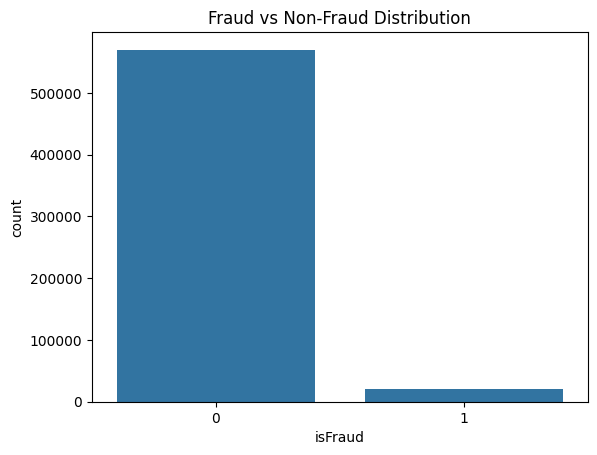

In [ ]:
# Fraud vs Non-Fraud counts
target_counts = train['isFraud'].value_counts()
print(target_counts)

# Percentage
fraud_ratio = train['isFraud'].mean() * 100
print(f"Fraud ratio: {fraud_ratio:.2f}%")

# Quick bar plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='isFraud', data=train)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# ==== Step 3: Missing Values & Data Types ====

In [ ]:
# % missing per column
missing = train.isnull().mean().sort_values(ascending=False) * 100

# Top 20 columns with most missing
print(missing.head(20))

# Quick summary of dtypes
print("\nData types summary:")
print(train.dtypes.value_counts())

dist2    93.628374
D7       93.409930
D13      89.509263
D14      89.469469
D12      89.041047
D6       87.606767
D9       87.312290
D8       87.312290
V153     86.123717
V149     86.123717
V141     86.123717
V146     86.123717
V154     86.123717
V162     86.123717
V142     86.123717
V158     86.123717
V161     86.123717
V157     86.123717
V138     86.123717
V139     86.123717
dtype: float64

Data types summary:
float64    376
object      14
int64        4
Name: count, dtype: int64


# ==== Step 4: Transaction Amount Analysis ====


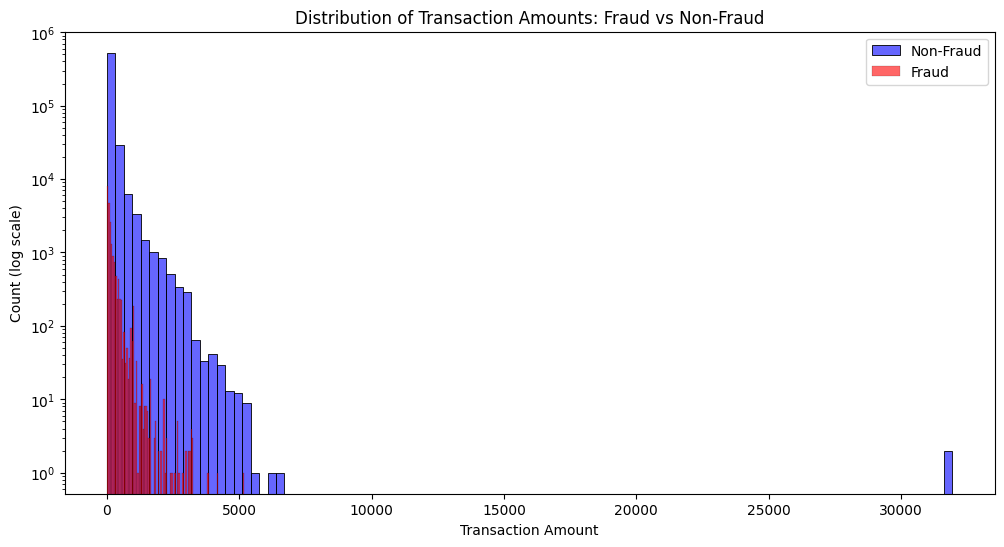

In [ ]:
# ==== Step 4: Transaction Amount Analysis ====

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(train[train['isFraud'] == 0]['TransactionAmt'], bins=100, color='blue', label='Non-Fraud', alpha=0.6)
sns.histplot(train[train['isFraud'] == 1]['TransactionAmt'], bins=100, color='red', label='Fraud', alpha=0.6)

plt.yscale('log')  # log scale because counts are skewed
plt.xlabel("Transaction Amount")
plt.ylabel("Count (log scale)")
plt.title("Distribution of Transaction Amounts: Fraud vs Non-Fraud")
plt.legend()
plt.show()

/tmp/ipython-input-1025884299.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[train['isFraud']==0]['TransactionAmt'],
/tmp/ipython-input-1025884299.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[train['isFraud']==1]['TransactionAmt'],


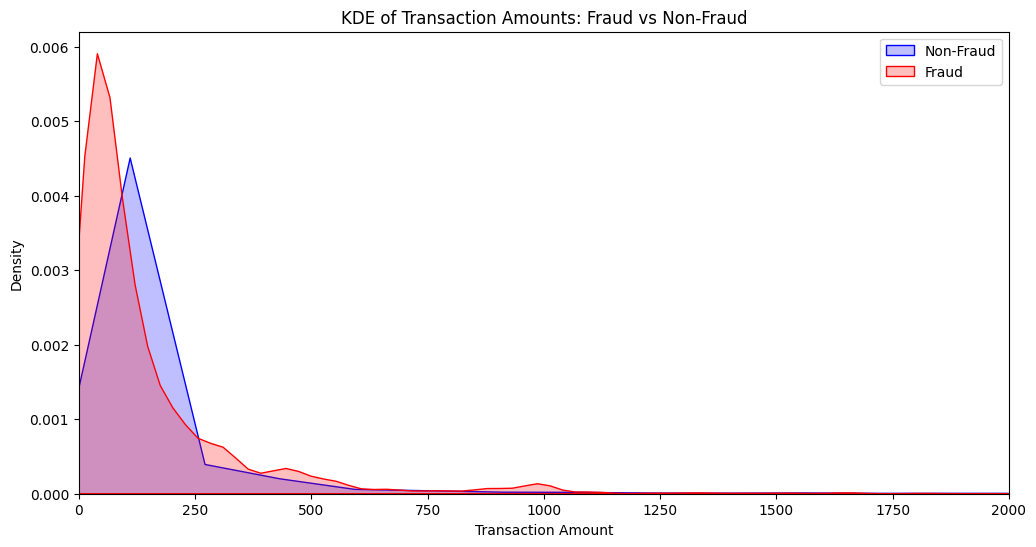

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(train[train['isFraud']==0]['TransactionAmt'],
            label="Non-Fraud", shade=True, color="blue")
sns.kdeplot(train[train['isFraud']==1]['TransactionAmt'],
            label="Fraud", shade=True, color="red")

plt.xlim(0, 2000)  # zoom in (most txns are low amounts)
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.title("KDE of Transaction Amounts: Fraud vs Non-Fraud")
plt.legend()
plt.show()

/tmp/ipython-input-290681550.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log1p(train[train['isFraud']==0]['TransactionAmt']),
/tmp/ipython-input-290681550.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log1p(train[train['isFraud']==1]['TransactionAmt']),


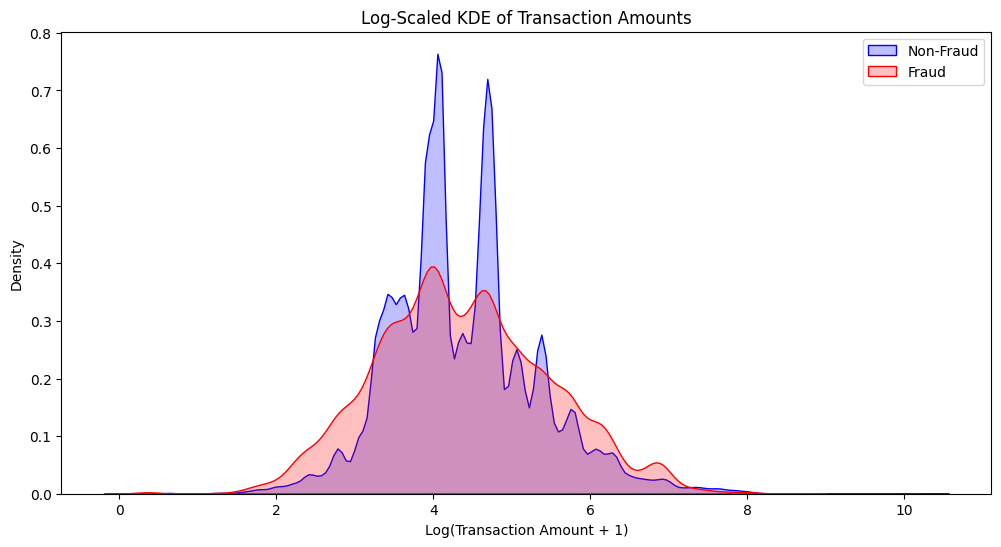

In [ ]:
import numpy as np

plt.figure(figsize=(12,6))
sns.kdeplot(np.log1p(train[train['isFraud']==0]['TransactionAmt']),
            label="Non-Fraud", shade=True, color="blue")
sns.kdeplot(np.log1p(train[train['isFraud']==1]['TransactionAmt']),
            label="Fraud", shade=True, color="red")

plt.xlabel("Log(Transaction Amount + 1)")
plt.ylabel("Density")
plt.title("Log-Scaled KDE of Transaction Amounts")
plt.legend()
plt.show()

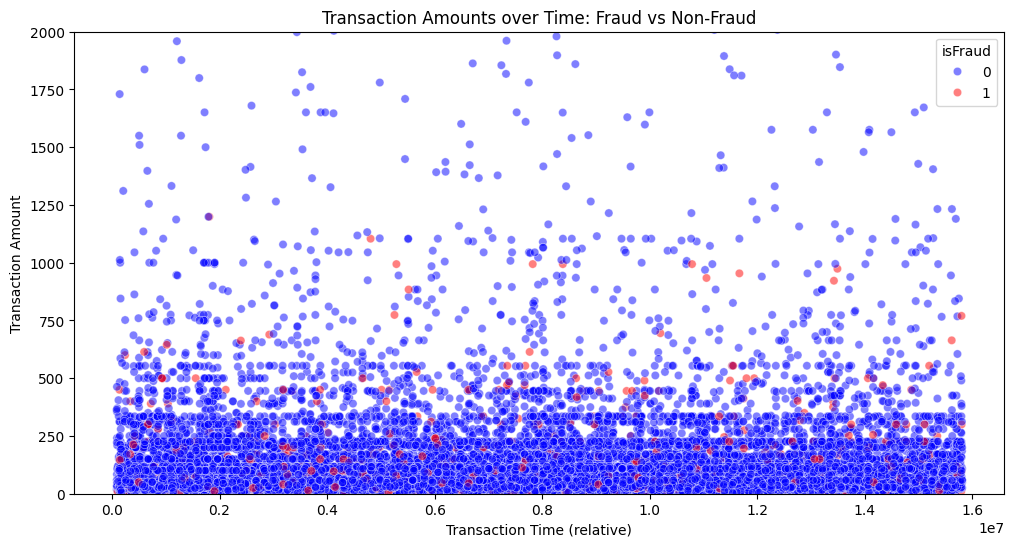

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='TransactionDT',
    y='TransactionAmt',
    hue='isFraud',
    data=train.sample(20000),  # sample for speed
    alpha=0.5,
    palette={0:"blue", 1:"red"}
)
plt.ylim(0, 2000)  # zoom in on lower amounts
plt.xlabel("Transaction Time (relative)")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amounts over Time: Fraud vs Non-Fraud")
plt.legend(title="isFraud")
plt.show()

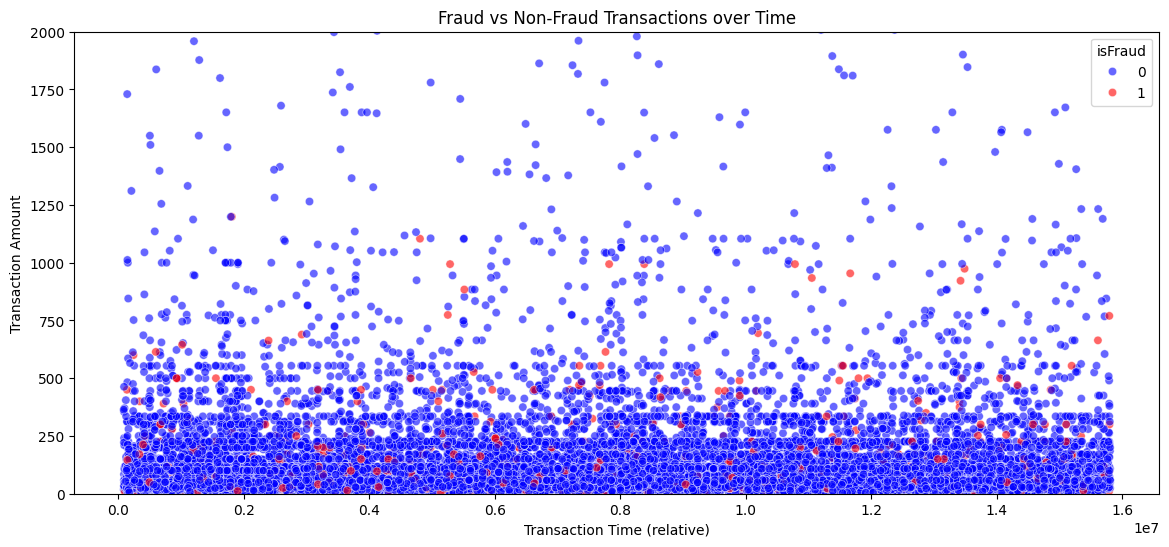

In [ ]:
plt.figure(figsize=(14,6))
sns.scatterplot(
    x='TransactionDT',
    y='TransactionAmt',
    hue='isFraud',
    data=train.sample(20000, random_state=42),  # sample for speed
    alpha=0.6,
    palette={0:"blue", 1:"red"}
)

plt.ylim(0, 2000)  # zoom in to low-mid amounts (most activity is here)
plt.xlabel("Transaction Time (relative)")
plt.ylabel("Transaction Amount")
plt.title("Fraud vs Non-Fraud Transactions over Time")
plt.legend(title="isFraud", loc="upper right")
plt.show()


#Fraud ratio over time (daily)

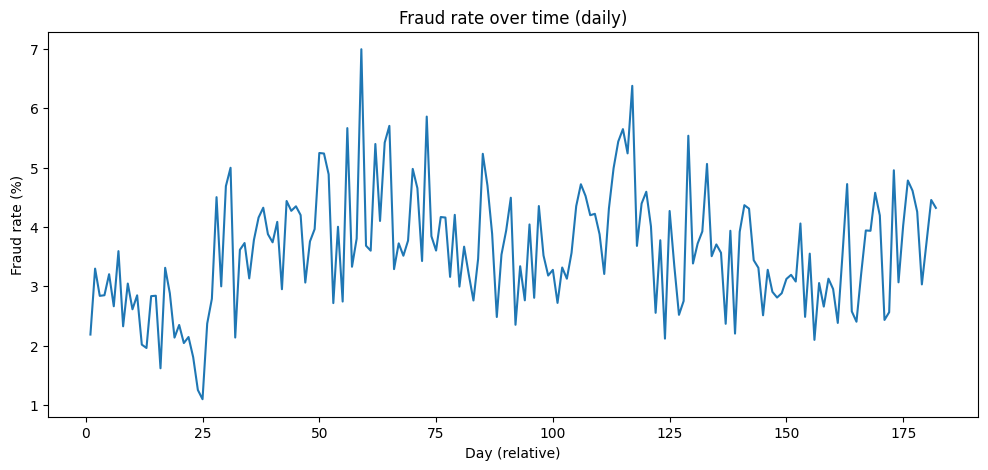

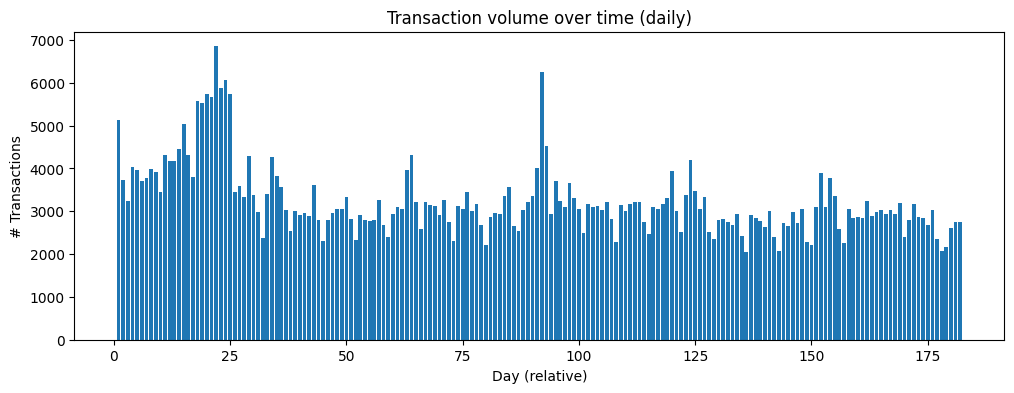

In [ ]:
# ==== Fraud ratio over time (daily) ====
import pandas as pd
import matplotlib.pyplot as plt

# TransactionDT is seconds from a start ref. Convert to days and then to an index.
df_time = train[['TransactionDT','isFraud']].copy()
df_time['day'] = (df_time['TransactionDT'] // 86400).astype(int)  # 86400 sec/day

daily = df_time.groupby('day').agg(
    txns=('isFraud','size'),
    frauds=('isFraud','sum')
).reset_index()
daily['fraud_rate'] = daily['frauds'] / daily['txns'] * 100

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(daily['day'], daily['fraud_rate'])
ax1.set_xlabel("Day (relative)")
ax1.set_ylabel("Fraud rate (%)")
ax1.set_title("Fraud rate over time (daily)")
plt.show()

# Optional: transactions volume to compare with fraud %
fig, ax2 = plt.subplots(figsize=(12,4))
ax2.bar(daily['day'], daily['txns'])
ax2.set_xlabel("Day (relative)")
ax2.set_ylabel("# Transactions")
ax2.set_title("Transaction volume over time (daily)")
plt.show()

# ==== Step 7.1: Numerical Features Summary ====

In [ ]:
num_cols = train.select_dtypes(include=['float64','int64']).columns
num_cols = [c for c in num_cols if c not in ['isFraud']]  # exclude target

print("Number of numeric columns:", len(num_cols))

# Summary stats
train[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).transpose().head(15)

Number of numeric columns: 379


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,2992905.390,3016526.95,3134634.750,3282269.500,3429904.25,3548012.05,3571633.61,3.577539e+06
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,185058.820,751946.50,3027057.750,7306527.500,11246620.00,14857872.15,15629766.04,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,9.244,20.00,43.321,68.769,125.00,445.00,1104.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,1338.000,2039.00,6019.000,9678.000,14184.00,17319.00,18238.00,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,100.000,111.00,214.000,361.000,512.00,567.00,583.00,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,144.000,150.00,150.000,150.000,150.00,185.00,185.00,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,102.000,102.00,166.000,226.000,226.00,226.00,226.00,2.370000e+02
addr1,524834.0,2.907338e+02,1.017411e+02,100.000,123.000,126.00,204.000,299.000,330.00,485.00,512.00,5.400000e+02
addr2,524834.0,8.680063e+01,2.690623e+00,10.000,87.000,87.00,87.000,87.000,87.00,87.00,87.00,1.020000e+02
dist1,238269.0,1.185022e+02,3.718720e+02,0.000,0.000,0.00,3.000,8.000,24.00,846.00,2040.00,1.028600e+04


# ==== Step 7.2: Correlation with target ====

/tmp/ipython-input-1082538555.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_corr.index, x=top_corr.values, palette="coolwarm")


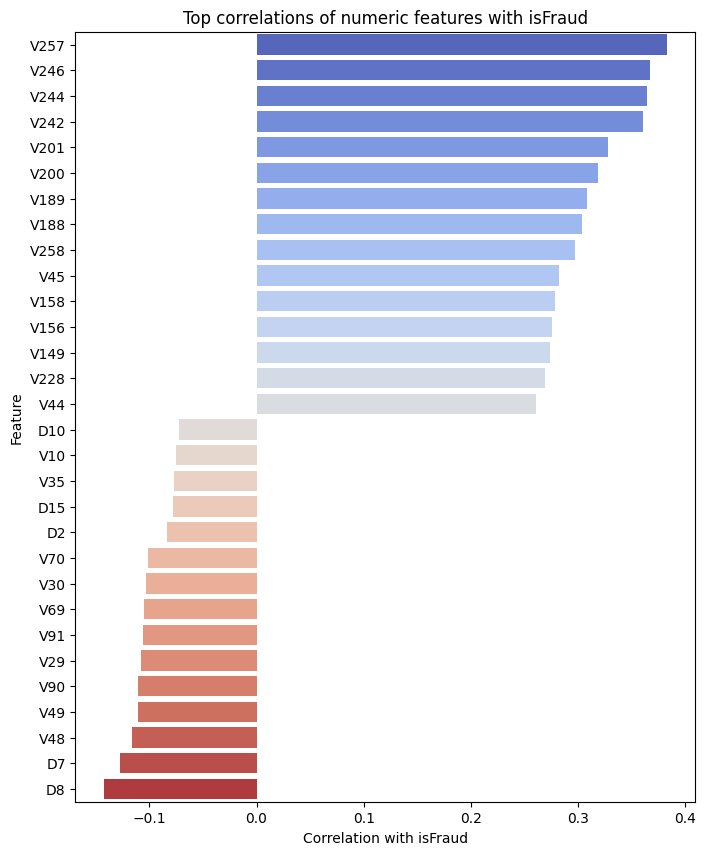

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

corr_with_target = train.corr(numeric_only=True)['isFraud'].drop('isFraud').sort_values(ascending=False)

# Top 15 positive + negative correlations
top_corr = pd.concat([corr_with_target.head(15), corr_with_target.tail(15)])

plt.figure(figsize=(8,10))
sns.barplot(y=top_corr.index, x=top_corr.values, palette="coolwarm")
plt.title("Top correlations of numeric features with isFraud")
plt.xlabel("Correlation with isFraud")
plt.ylabel("Feature")
plt.show()


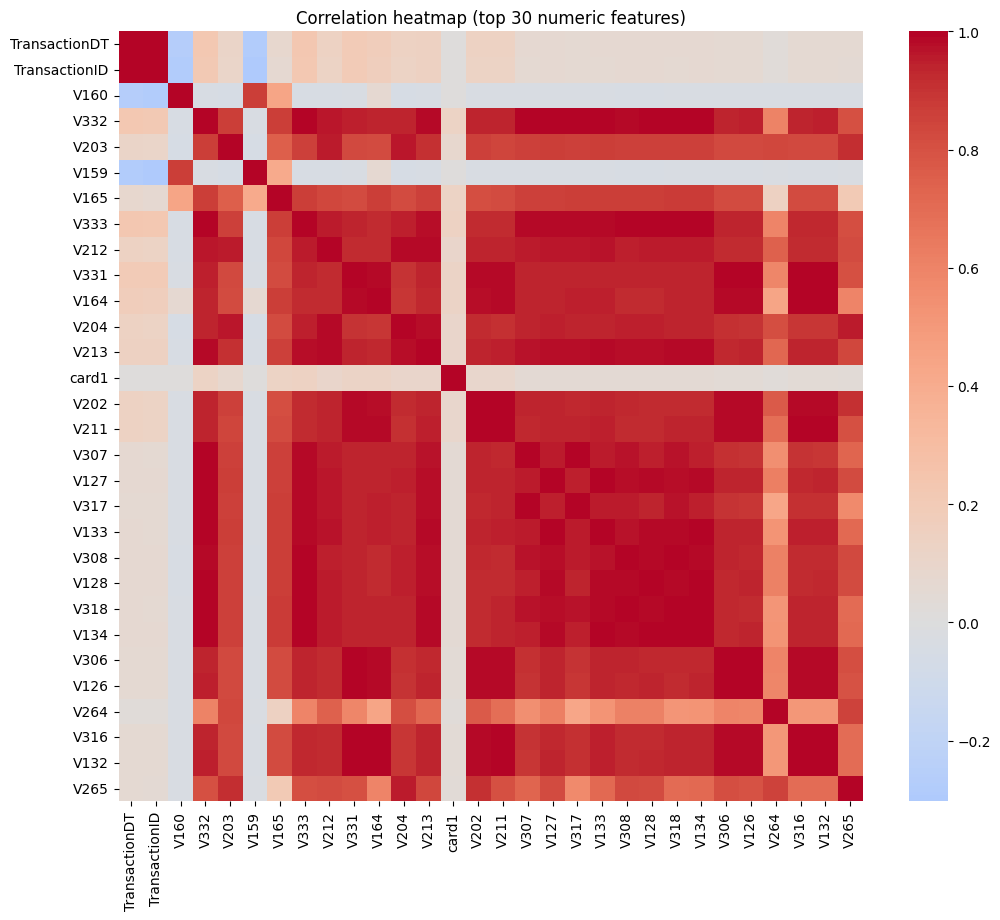

In [ ]:
# ==== Step 7.3: Multicollinearity check ====

# Correlation matrix of top 30 numeric features by variance
high_var_cols = train[num_cols].var().sort_values(ascending=False).head(30).index
corr_matrix = train[high_var_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (top 30 numeric features)")
plt.show()

# ==== Step 8.1: Merge transaction & identity ====

In [4]:
train_identity = pd.read_csv(CFG.RAW_DIR / "train_identity.csv")
test_identity  = pd.read_csv(CFG.RAW_DIR / "test_identity.csv")

print("Train identity shape:", train_identity.shape)
print("Test identity shape :", test_identity.shape)

# Merge with transaction data
train_full = train.merge(train_identity, on='TransactionID', how='left')
test_full  = test.merge(test_identity, on='TransactionID', how='left')

print("Merged train shape:", train_full.shape)
print("Merged test shape :", test_full.shape)


Train identity shape: (144233, 41)
Test identity shape : (141907, 41)
Merged train shape: (590540, 434)
Merged test shape : (506691, 433)


In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


from matplotlib import pyplot as plt
_df_0['TransactionID'].plot(kind='hist', bins=20, title='TransactionID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['id_01'].plot(kind='hist', bins=20, title='id_01')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['id_02'].plot(kind='hist', bins=20, title='id_02')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['id_03'].plot(kind='hist', bins=20, title='id_03')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('id_15').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('id_16').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('id_28').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('id_29').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='TransactionID', y='id_01', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='id_01', y='id_02', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='id_02', y='id_03', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='id_03', y='id_04', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TransactionID']
  ys = series['id_01']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('TransactionID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('id_15')):
  _plot_series(series, series_name, i)
  fig.legend(title='id_15', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TransactionID')
_ = plt.ylabel('id_01')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TransactionID']
  ys = series['id_01']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('TransactionID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('id_16')):
  _plot_series(series, series_name, i)
  fig.legend(title='id_16', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TransactionID')
_ = plt.ylabel('id_01')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TransactionID']
  ys = series['id_01']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('TransactionID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('id_28')):
  _plot_series(series, series_name, i)
  fig.legend(title='id_28', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TransactionID')
_ = plt.ylabel('id_01')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TransactionID']
  ys = series['id_01']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('TransactionID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('id_29')):
  _plot_series(series, series_name, i)
  fig.legend(title='id_29', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TransactionID')
_ = plt.ylabel('id_01')

from matplotlib import pyplot as plt
_df_16['TransactionID'].plot(kind='line', figsize=(8, 4), title='TransactionID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['id_01'].plot(kind='line', figsize=(8, 4), title='id_01')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['id_02'].plot(kind='line', figsize=(8, 4), title='id_02')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['id_03'].plot(kind='line', figsize=(8, 4), title='id_03')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['id_16'].value_counts()
    for x_label, grp in _df_20.groupby('id_15')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('id_15')
_ = plt.ylabel('id_16')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['id_28'].value_counts()
    for x_label, grp in _df_21.groupby('id_16')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('id_16')
_ = plt.ylabel('id_28')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['id_29'].value_counts()
    for x_label, grp in _df_22.groupby('id_28')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('id_28')
_ = plt.ylabel('id_29')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['id_30'].value_counts()
    for x_label, grp in _df_23.groupby('id_29')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('id_29')
_ = plt.ylabel('id_30')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['id_15'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='TransactionID', y='id_15', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['id_16'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='TransactionID', y='id_16', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['id_28'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='TransactionID', y='id_28', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['id_29'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='TransactionID', y='id_29', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# ==== Step 8.2: Fraud rates by identity features ====


Fraud rate by DeviceType:


,DeviceType,txns,frauds,fraud_rate
0,desktop,85165,5554,6.521458
1,mobile,55645,5657,10.166232


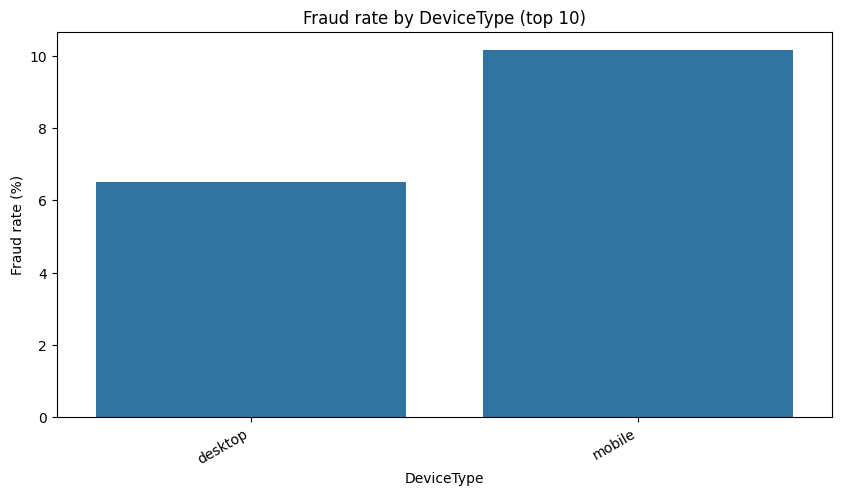


Fraud rate by DeviceInfo:


,DeviceInfo,txns,frauds,fraud_rate
1598,Windows,47722,3121,6.539961
1727,iOS Device,19782,1240,6.268325
723,MacOS,12573,278,2.211087
1552,Trident/7.0,7440,96,1.290323
1743,rv:11.0,1901,76,3.997896
1769,rv:57.0,962,103,10.706861
1360,SM-J700M Build/MMB29K,549,60,10.928962


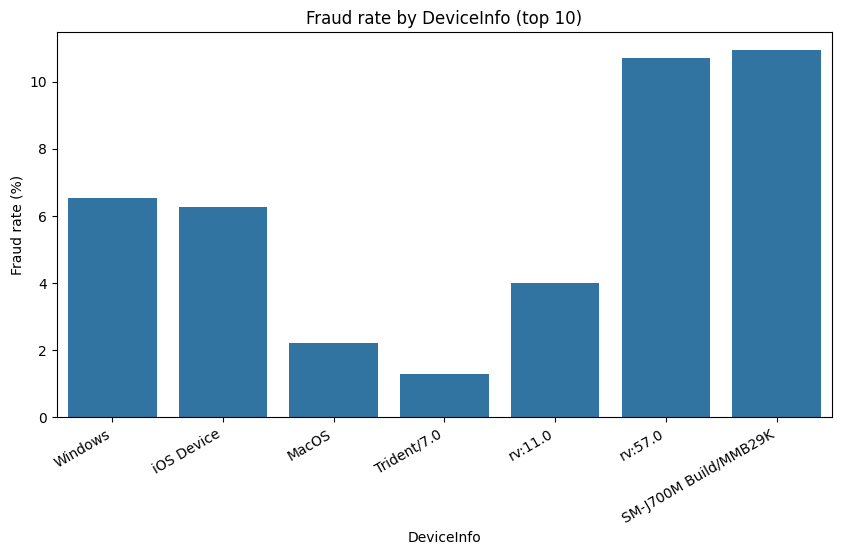


Fraud rate by id_30:


,id_30,txns,frauds,fraud_rate
42,Windows 10,21155,657,3.105649
43,Windows 7,13110,432,3.295195
65,iOS 11.2.1,3722,183,4.916711
63,iOS 11.1.2,3699,130,3.514463
7,Android 7.0,2871,166,5.781958
31,Mac OS X 10_12_6,2559,36,1.406800
24,Mac OS X 10_11_6,2348,29,1.235094
69,iOS 11.3.0,2016,138,6.845238
45,Windows 8.1,1914,133,6.948798
20,Mac OS X 10_10_5,1651,41,2.483343


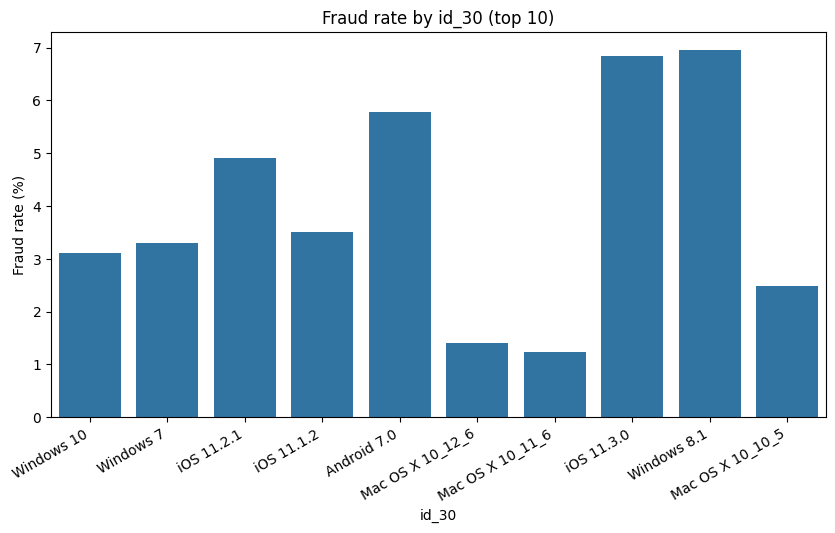


Fraud rate by id_31:


,id_31,txns,frauds,fraud_rate
47,chrome 63.0,22000,1503,6.831818
98,mobile safari 11.0,13423,842,6.272815
101,mobile safari generic,11474,1146,9.987799
91,ie 11.0 for desktop,9030,175,1.937984
116,safari generic,8195,205,2.501525
44,chrome 62.0,7182,299,4.163186
53,chrome 65.0,6871,679,9.882113
50,chrome 64.0,6711,615,9.164059
48,chrome 63.0 for android,5806,653,11.246986
62,chrome generic,4778,803,16.806195


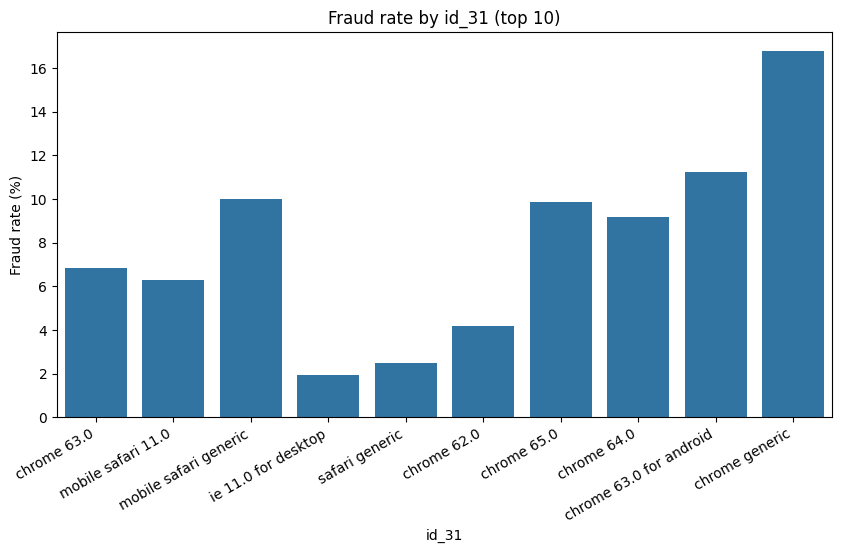


Fraud rate by id_33:


,id_33,txns,frauds,fraud_rate
132,1920x1080,16874,490,2.903876
60,1366x768,8605,493,5.729227
48,1334x750,6447,381,5.909725
163,2208x1242,4900,482,9.836735
77,1440x900,4384,128,2.919708
98,1600x900,3510,113,3.219373
149,2048x1536,3482,65,1.866743
40,1280x800,2149,103,4.792927
183,2560x1600,2093,43,2.054467
182,2560x1440,1865,14,0.750670


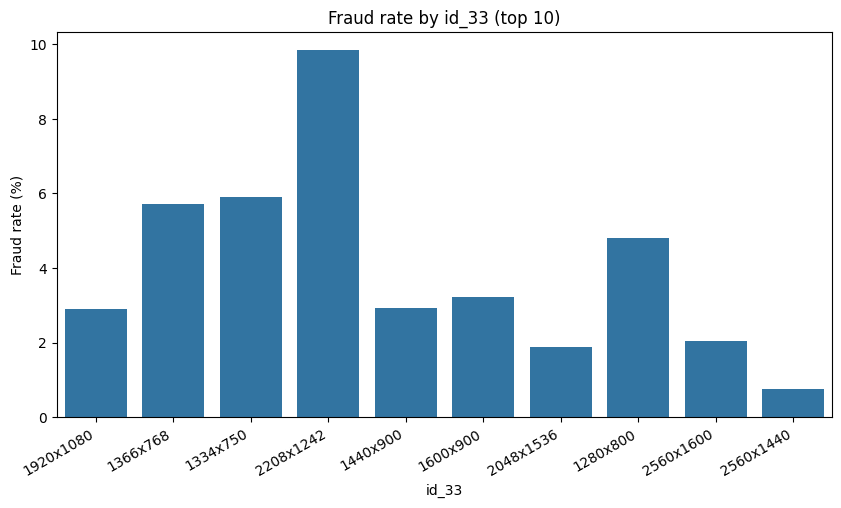

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def fraud_rate_by_cat(df, col, top_k=10, min_count=500):
    tmp = df[[col,'isFraud']].copy()
    tmp[col] = tmp[col].astype('object')
    grp = tmp.groupby(col).agg(
        txns=('isFraud','size'),
        frauds=('isFraud','sum')
    ).reset_index()
    grp['fraud_rate'] = grp['frauds'] / grp['txns'] * 100
    grp = grp.sort_values('txns', ascending=False)
    grp = grp[grp['txns'] >= min_count].head(top_k)

    print(f"\nFraud rate by {col}:")
    display(grp)

    plt.figure(figsize=(10,5))
    sns.barplot(data=grp, x=col, y='fraud_rate')
    plt.xticks(rotation=30, ha='right')
    plt.title(f"Fraud rate by {col} (top {top_k})")
    plt.ylabel("Fraud rate (%)")
    plt.show()

# Check identity-related categorical features
for col in ['DeviceType','DeviceInfo','id_30','id_31','id_33']:
    fraud_rate_by_cat(train_full, col, top_k=10, min_count=500)

Why this matters

These features give us behavioral fingerprints:

Legitimate users → common devices, updated OS, normal resolutions.

Fraudsters → outdated devices, rare browsers, emulators, generic IDs.

This is why identity features are gold in fraud detection. Even if their correlations aren’t huge, when combined with transaction data they are very powerful.

### - Fraud rates vary strongly by DeviceType, DeviceInfo, OS, Browser, Resolution.

### - This tells us these features will be very useful in modeling (after cleaning + encoding)

# Step 9.1 Card Type × DeviceType

This step is about uncovering fraud signals that only appear when two features are combined — because fraudsters often exploit unusual combinations (e.g., a Visa debit card on an Android emulator, or a credit card from US address used with an unknown browser).

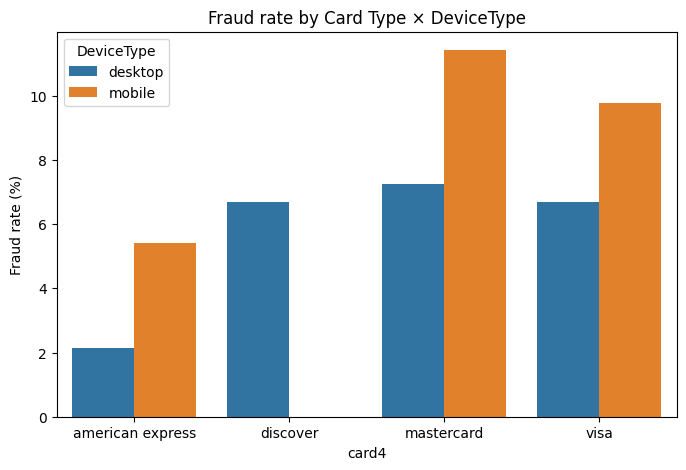

,card4,DeviceType,txns,frauds,fraud_rate
5,mastercard,mobile,17738,2027,11.427444
7,visa,mobile,35208,3445,9.784708
4,mastercard,desktop,25543,1850,7.242689
2,discover,desktop,1521,102,6.706114
6,visa,desktop,51888,3468,6.683626
1,american express,mobile,1916,104,5.427975
0,american express,desktop,6124,131,2.139125


In [9]:
cross = train_full.groupby(['card4','DeviceType']).agg(
    txns=('isFraud','size'),
    frauds=('isFraud','sum')
).reset_index()
cross['fraud_rate'] = cross['frauds'] / cross['txns'] * 100
cross = cross[cross['txns'] > 1000]  # filter low counts

plt.figure(figsize=(8,5))
sns.barplot(data=cross, x='card4', y='fraud_rate', hue='DeviceType')
plt.title("Fraud rate by Card Type × DeviceType")
plt.ylabel("Fraud rate (%)")
plt.show()

display(cross.sort_values('fraud_rate', ascending=False))

# Step 9.2  Fraud rate by ProductCD × OS (id_30)



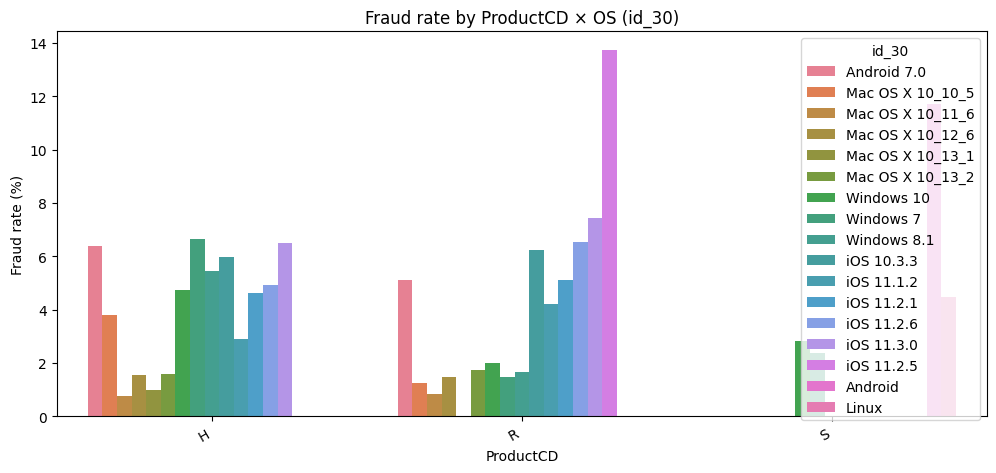

,ProductCD,id_30,txns,frauds,fraud_rate
140,R,iOS 11.2.5,626,86,13.738019
147,S,Android,907,106,11.686880
142,R,iOS 11.3.0,1063,79,7.431797
43,H,Windows 7,4286,285,6.649557
141,R,iOS 11.2.6,798,52,6.516291
69,H,iOS 11.3.0,861,56,6.504065
7,H,Android 7.0,1690,108,6.390533
129,R,iOS 10.3.3,690,43,6.231884
56,H,iOS 10.3.3,770,46,5.974026
45,H,Windows 8.1,660,36,5.454545


In [11]:
cross = train_full.groupby(['ProductCD','id_30']).agg(
    txns=('isFraud','size'),
    frauds=('isFraud','sum')
).reset_index()

cross['fraud_rate'] = cross['frauds'] / cross['txns'] * 100
cross = cross[cross['txns'] > 500]  # filter rare combos

plt.figure(figsize=(12,5))
sns.barplot(data=cross, x='ProductCD', y='fraud_rate', hue='id_30')
plt.title("Fraud rate by ProductCD × OS (id_30)")
plt.ylabel("Fraud rate (%)")
plt.xticks(rotation=30, ha='right')
plt.show()

display(cross.sort_values('fraud_rate', ascending=False).head(10))

Cross-Feature Fraud Rate Helper

In [12]:
def cross_fraud_rate(df, col1, col2, min_count=500, top_k=15):
    """
    Calculate and plot fraud rate by two categorical features.
    """
    tmp = df[[col1, col2, 'isFraud']].copy()
    tmp[col1] = tmp[col1].astype('object')
    tmp[col2] = tmp[col2].astype('object')

    grp = tmp.groupby([col1, col2]).agg(
        txns=('isFraud','size'),
        frauds=('isFraud','sum')
    ).reset_index()
    grp['fraud_rate'] = grp['frauds'] / grp['txns'] * 100

    # filter rare combos
    grp = grp[grp['txns'] >= min_count]

    # sort by fraud rate
    grp_sorted = grp.sort_values('fraud_rate', ascending=False).head(top_k)

    print(f"\nTop {top_k} fraud-prone combinations: {col1} × {col2}")
    display(grp_sorted)

    # plot
    plt.figure(figsize=(12,6))
    sns.barplot(data=grp_sorted, x=col1, y='fraud_rate', hue=col2)
    plt.title(f"Fraud rate by {col1} × {col2}")
    plt.ylabel("Fraud rate (%)")
    plt.xticks(rotation=30, ha='right')
    plt.show()

    return grp_sorted


Top 15 fraud-prone combinations: card4 × DeviceType


,card4,DeviceType,txns,frauds,fraud_rate
5,mastercard,mobile,17738,2027,11.427444
3,discover,mobile,689,70,10.159652
7,visa,mobile,35208,3445,9.784708
4,mastercard,desktop,25543,1850,7.242689
2,discover,desktop,1521,102,6.706114
6,visa,desktop,51888,3468,6.683626
1,american express,mobile,1916,104,5.427975
0,american express,desktop,6124,131,2.139125


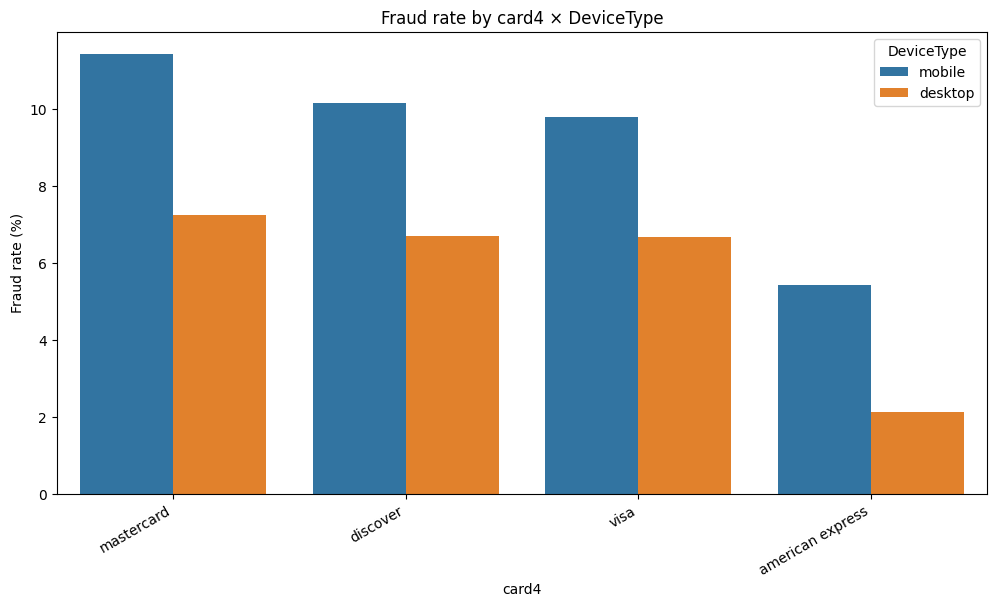

,card4,DeviceType,txns,frauds,fraud_rate
5,mastercard,mobile,17738,2027,11.427444
3,discover,mobile,689,70,10.159652
7,visa,mobile,35208,3445,9.784708
4,mastercard,desktop,25543,1850,7.242689
2,discover,desktop,1521,102,6.706114
6,visa,desktop,51888,3468,6.683626
1,american express,mobile,1916,104,5.427975
0,american express,desktop,6124,131,2.139125


In [13]:
cross_fraud_rate(train_full, 'card4', 'DeviceType')


Top 15 fraud-prone combinations: ProductCD × id_30


,ProductCD,id_30,txns,frauds,fraud_rate
140,R,iOS 11.2.5,626,86,13.738019
147,S,Android,907,106,11.686880
142,R,iOS 11.3.0,1063,79,7.431797
43,H,Windows 7,4286,285,6.649557
141,R,iOS 11.2.6,798,52,6.516291
69,H,iOS 11.3.0,861,56,6.504065
7,H,Android 7.0,1690,108,6.390533
129,R,iOS 10.3.3,690,43,6.231884
56,H,iOS 10.3.3,770,46,5.974026
45,H,Windows 8.1,660,36,5.454545


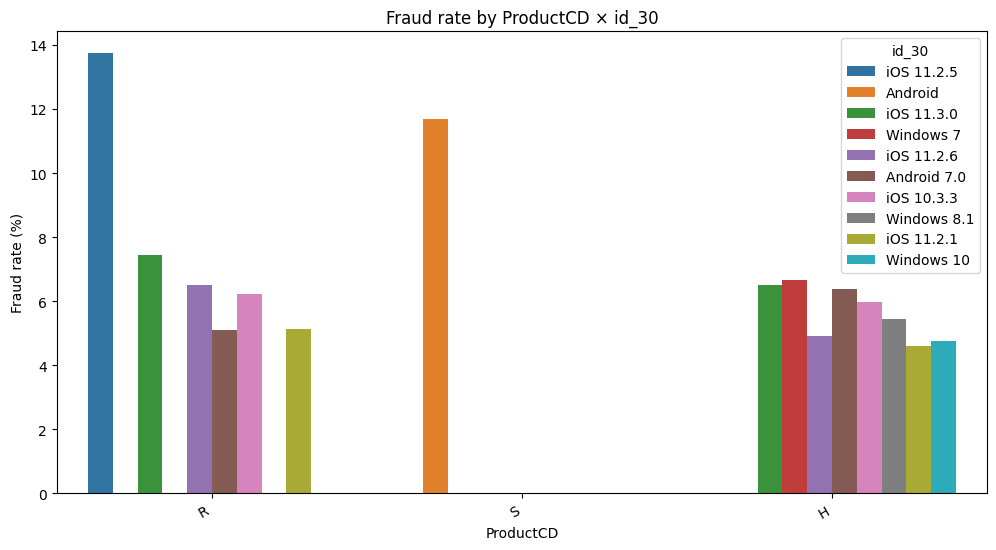

,ProductCD,id_30,txns,frauds,fraud_rate
140,R,iOS 11.2.5,626,86,13.738019
147,S,Android,907,106,11.686880
142,R,iOS 11.3.0,1063,79,7.431797
43,H,Windows 7,4286,285,6.649557
141,R,iOS 11.2.6,798,52,6.516291
69,H,iOS 11.3.0,861,56,6.504065
7,H,Android 7.0,1690,108,6.390533
129,R,iOS 10.3.3,690,43,6.231884
56,H,iOS 10.3.3,770,46,5.974026
45,H,Windows 8.1,660,36,5.454545


In [14]:
cross_fraud_rate(train_full, 'ProductCD', 'id_30')


Top 15 fraud-prone combinations: card6 × id_31


,card6,id_31,txns,frauds,fraud_rate
52,credit,chrome 64.0 for android,1249,389,31.144916
62,credit,chrome generic,1974,451,22.847011
55,credit,chrome 65.0 for android,1154,263,22.790295
49,credit,chrome 63.0 for android,2104,414,19.676806
58,credit,chrome 66.0 for android,803,156,19.427148
46,credit,chrome 62.0 for android,710,94,13.239437
184,debit,chrome generic,2803,352,12.557974
54,credit,chrome 65.0,3508,394,11.231471
51,credit,chrome 64.0,3348,374,11.170848
97,credit,mobile safari generic,5623,623,11.079495


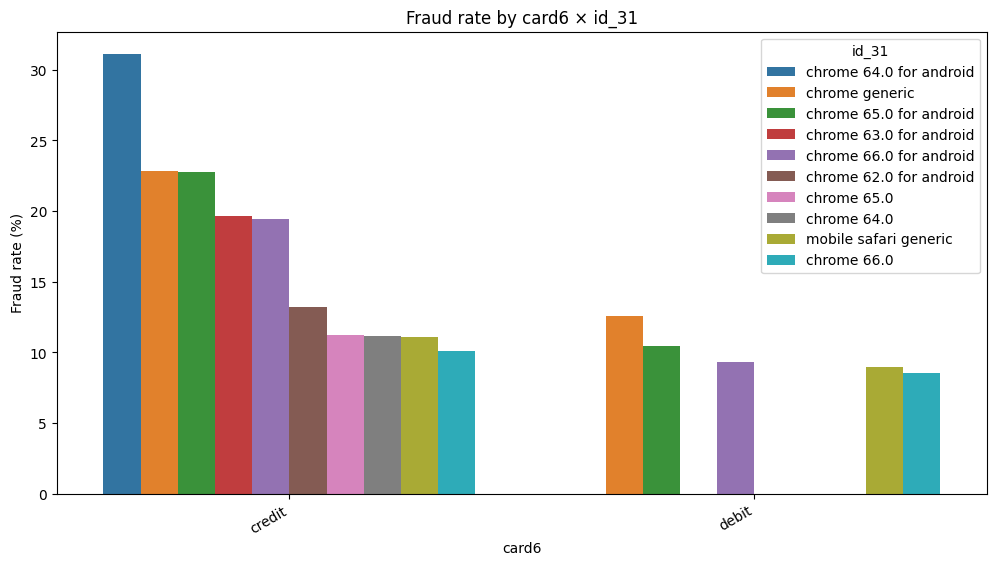

,card6,id_31,txns,frauds,fraud_rate
52,credit,chrome 64.0 for android,1249,389,31.144916
62,credit,chrome generic,1974,451,22.847011
55,credit,chrome 65.0 for android,1154,263,22.790295
49,credit,chrome 63.0 for android,2104,414,19.676806
58,credit,chrome 66.0 for android,803,156,19.427148
46,credit,chrome 62.0 for android,710,94,13.239437
184,debit,chrome generic,2803,352,12.557974
54,credit,chrome 65.0,3508,394,11.231471
51,credit,chrome 64.0,3348,374,11.170848
97,credit,mobile safari generic,5623,623,11.079495


In [15]:
cross_fraud_rate(train_full, 'card6', 'id_31')


Top 15 fraud-prone combinations: P_emaildomain × DeviceType


,P_emaildomain,DeviceType,txns,frauds,fraud_rate
70,outlook.com,desktop,1298,260,20.030817
71,outlook.com,mobile,1018,159,15.618861
33,gmail.com,mobile,24038,3304,13.744904
47,icloud.com,mobile,610,77,12.622951
32,gmail.com,desktop,28854,2930,10.154571
39,hotmail.com,mobile,11873,1026,8.641455
3,anonymous.com,mobile,3714,283,7.619817
38,hotmail.com,desktop,13419,1002,7.467024
106,yahoo.com,mobile,5156,280,5.430566
105,yahoo.com,desktop,6237,205,3.286837


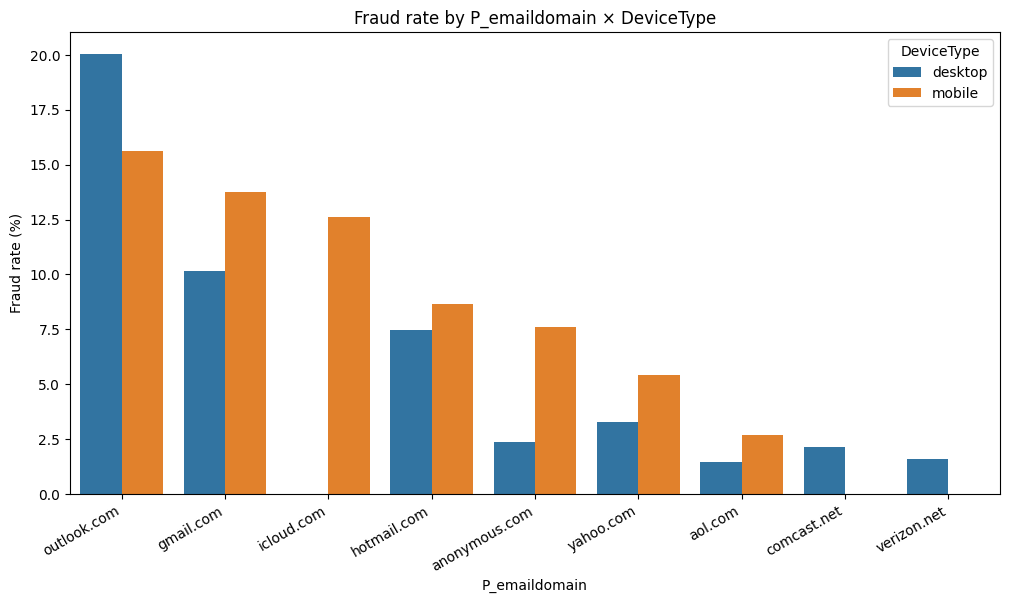

,P_emaildomain,DeviceType,txns,frauds,fraud_rate
70,outlook.com,desktop,1298,260,20.030817
71,outlook.com,mobile,1018,159,15.618861
33,gmail.com,mobile,24038,3304,13.744904
47,icloud.com,mobile,610,77,12.622951
32,gmail.com,desktop,28854,2930,10.154571
39,hotmail.com,mobile,11873,1026,8.641455
3,anonymous.com,mobile,3714,283,7.619817
38,hotmail.com,desktop,13419,1002,7.467024
106,yahoo.com,mobile,5156,280,5.430566
105,yahoo.com,desktop,6237,205,3.286837


In [16]:
cross_fraud_rate(train_full, 'P_emaildomain', 'DeviceType')

Function helper that saves the insight for interaction features

In [17]:
def cross_fraud_rate(df, col1, col2, min_count=500, top_k=15, save=True):
    """
    Calculate, plot, and optionally save fraud rate by two categorical features.
    """
    tmp = df[[col1, col2, 'isFraud']].copy()
    tmp[col1] = tmp[col1].astype('object')
    tmp[col2] = tmp[col2].astype('object')

    grp = tmp.groupby([col1, col2]).agg(
        txns=('isFraud','size'),
        frauds=('isFraud','sum')
    ).reset_index()
    grp['fraud_rate'] = grp['frauds'] / grp['txns'] * 100

    # filter rare combos
    grp = grp[grp['txns'] >= min_count]

    # sort by fraud rate
    grp_sorted = grp.sort_values('fraud_rate', ascending=False).head(top_k)

    print(f"\nTop {top_k} fraud-prone combinations: {col1} × {col2}")
    display(grp_sorted)

    # plot
    plt.figure(figsize=(12,6))
    sns.barplot(data=grp_sorted, x=col1, y='fraud_rate', hue=col2)
    plt.title(f"Fraud rate by {col1} × {col2}")
    plt.ylabel("Fraud rate (%)")
    plt.xticks(rotation=30, ha='right')
    plt.show()

    # save CSV
    if save:
        out_path = CFG.ARTIFACTS_DIR / f"fraudrate_{col1}_{col2}.csv"
        grp_sorted.to_csv(out_path, index=False)
        print(f"✅ Saved results to {out_path}")

    return grp_sorted


Batch cross feature analysis


Top 15 fraud-prone combinations: card4 × DeviceType


,card4,DeviceType,txns,frauds,fraud_rate
5,mastercard,mobile,17738,2027,11.427444
3,discover,mobile,689,70,10.159652
7,visa,mobile,35208,3445,9.784708
4,mastercard,desktop,25543,1850,7.242689
2,discover,desktop,1521,102,6.706114
6,visa,desktop,51888,3468,6.683626
1,american express,mobile,1916,104,5.427975
0,american express,desktop,6124,131,2.139125


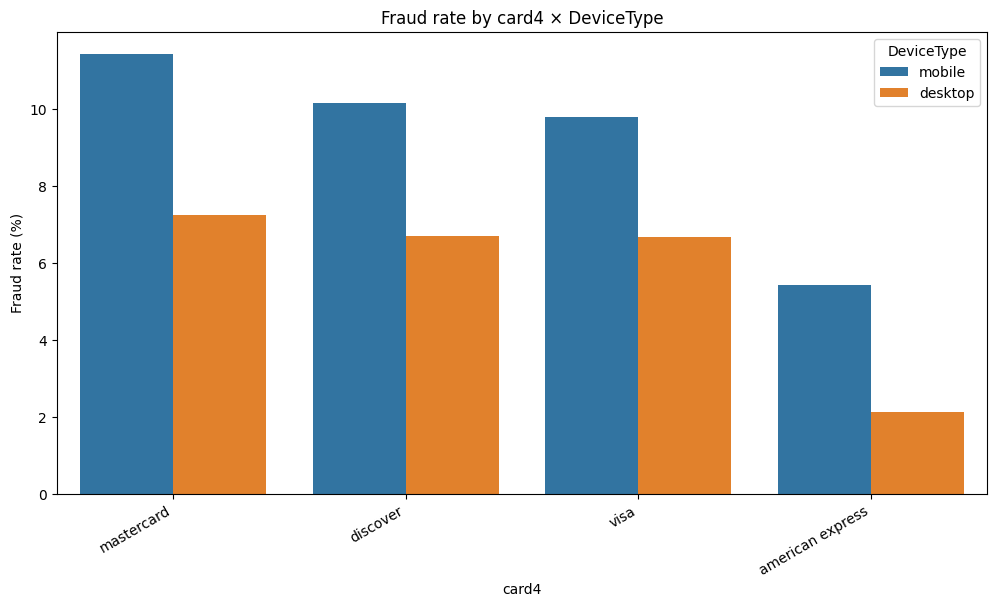

✅ Saved results to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/fraudrate_card4_DeviceType.csv

Top 15 fraud-prone combinations: ProductCD × id_30


,ProductCD,id_30,txns,frauds,fraud_rate
140,R,iOS 11.2.5,626,86,13.738019
147,S,Android,907,106,11.686880
142,R,iOS 11.3.0,1063,79,7.431797
43,H,Windows 7,4286,285,6.649557
141,R,iOS 11.2.6,798,52,6.516291
69,H,iOS 11.3.0,861,56,6.504065
7,H,Android 7.0,1690,108,6.390533
129,R,iOS 10.3.3,690,43,6.231884
56,H,iOS 10.3.3,770,46,5.974026
45,H,Windows 8.1,660,36,5.454545


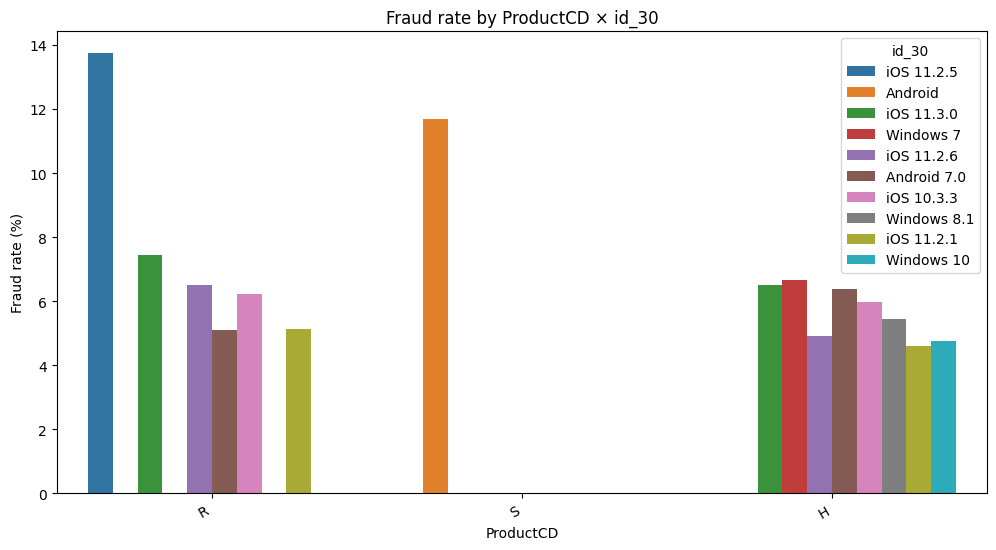

✅ Saved results to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/fraudrate_ProductCD_id_30.csv

Top 15 fraud-prone combinations: card6 × id_31


,card6,id_31,txns,frauds,fraud_rate
52,credit,chrome 64.0 for android,1249,389,31.144916
62,credit,chrome generic,1974,451,22.847011
55,credit,chrome 65.0 for android,1154,263,22.790295
49,credit,chrome 63.0 for android,2104,414,19.676806
58,credit,chrome 66.0 for android,803,156,19.427148
46,credit,chrome 62.0 for android,710,94,13.239437
184,debit,chrome generic,2803,352,12.557974
54,credit,chrome 65.0,3508,394,11.231471
51,credit,chrome 64.0,3348,374,11.170848
97,credit,mobile safari generic,5623,623,11.079495


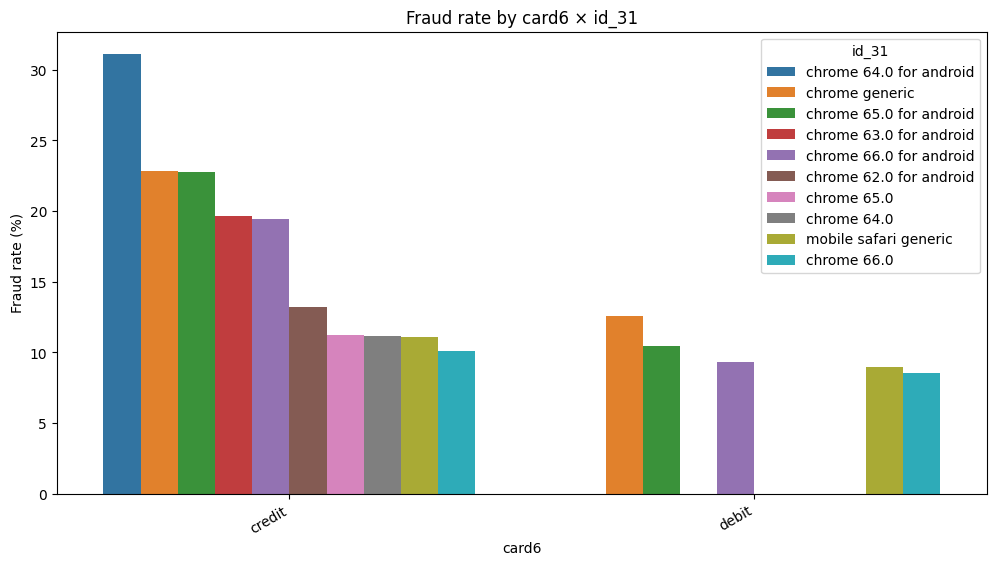

✅ Saved results to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/fraudrate_card6_id_31.csv

Top 15 fraud-prone combinations: P_emaildomain × DeviceType


,P_emaildomain,DeviceType,txns,frauds,fraud_rate
70,outlook.com,desktop,1298,260,20.030817
71,outlook.com,mobile,1018,159,15.618861
33,gmail.com,mobile,24038,3304,13.744904
47,icloud.com,mobile,610,77,12.622951
32,gmail.com,desktop,28854,2930,10.154571
39,hotmail.com,mobile,11873,1026,8.641455
3,anonymous.com,mobile,3714,283,7.619817
38,hotmail.com,desktop,13419,1002,7.467024
106,yahoo.com,mobile,5156,280,5.430566
105,yahoo.com,desktop,6237,205,3.286837


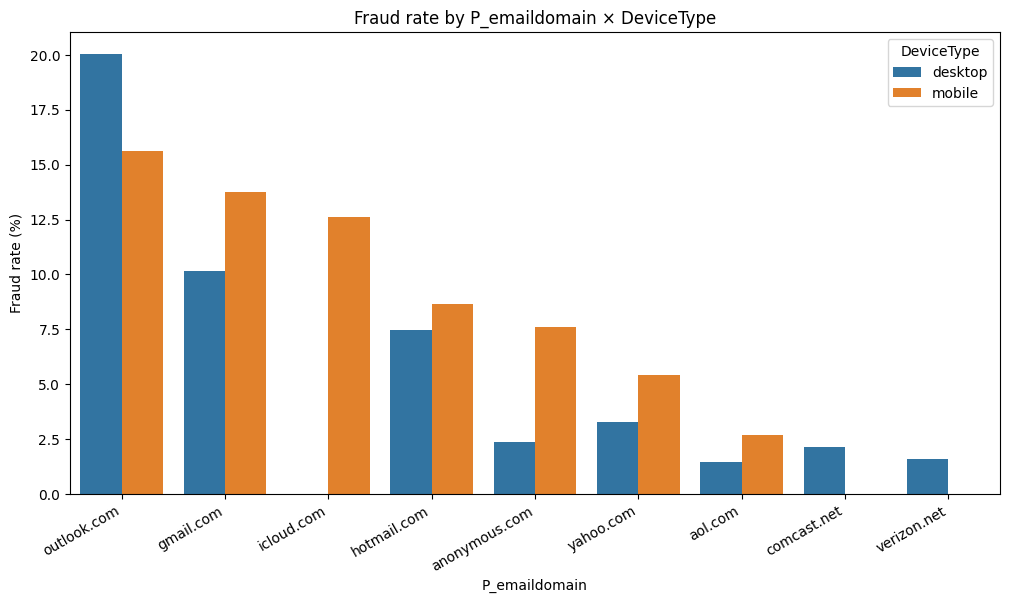

✅ Saved results to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/fraudrate_P_emaildomain_DeviceType.csv

Top 15 fraud-prone combinations: addr1 × DeviceType


,addr1,DeviceType,txns,frauds,fraud_rate
15,123.0,mobile,586,78,13.310580
141,272.0,desktop,1329,162,12.189616
182,330.0,mobile,1752,170,9.703196
170,315.0,mobile,970,89,9.175258
142,272.0,mobile,793,68,8.575032
175,325.0,mobile,1804,151,8.370288
136,264.0,mobile,1597,127,7.952411
269,441.0,mobile,991,78,7.870838
189,337.0,mobile,1034,77,7.446809
14,123.0,desktop,1222,83,6.792144


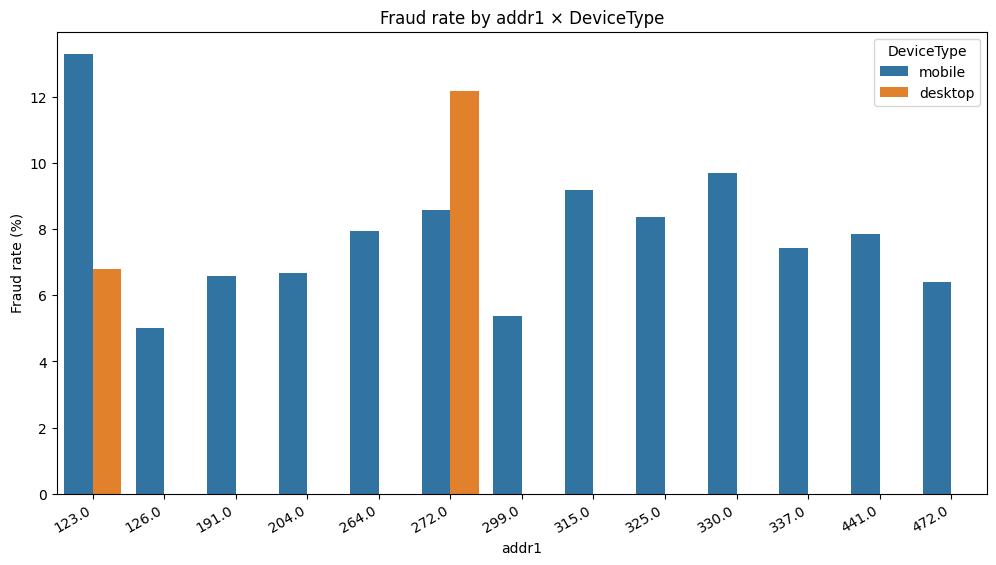

✅ Saved results to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/fraudrate_addr1_DeviceType.csv

Top 15 fraud-prone combinations: card4 × id_31


,card4,id_31,txns,frauds,fraud_rate
205,mastercard,chrome generic,1663,315,18.941672
314,visa,chrome 64.0 for android,2131,360,16.893477
325,visa,chrome generic,2974,478,16.072629
317,visa,chrome 65.0 for android,2067,317,15.336236
202,mastercard,chrome 66.0 for android,925,134,14.486486
196,mastercard,chrome 64.0 for android,1292,183,14.164087
199,mastercard,chrome 65.0 for android,1236,169,13.673139
193,mastercard,chrome 63.0 for android,2047,245,11.968735
320,visa,chrome 66.0 for android,1368,162,11.842105
240,mastercard,mobile safari generic,3475,406,11.683453


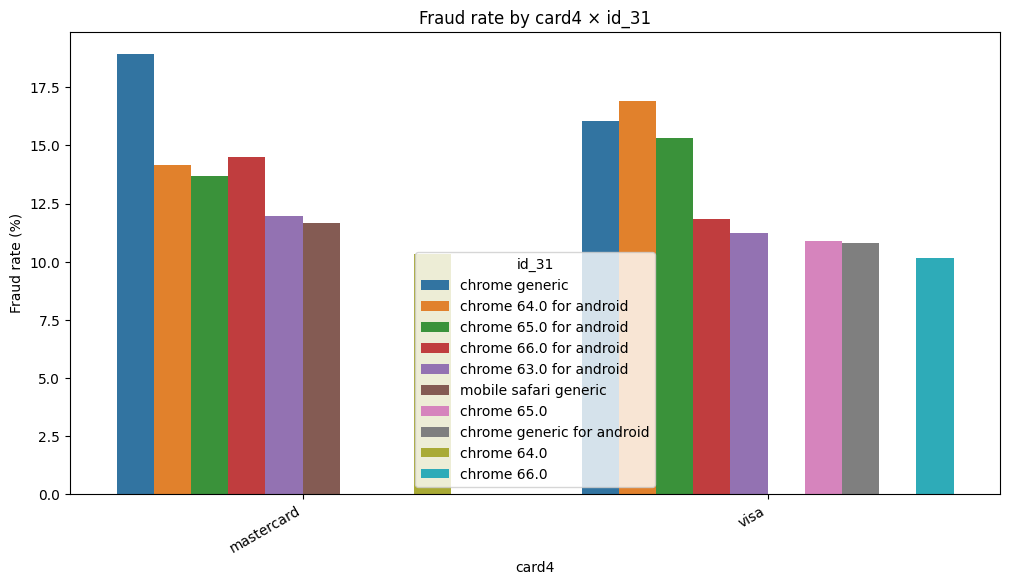

✅ Saved results to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/fraudrate_card4_id_31.csv


In [18]:
pairs = [
    ('card4','DeviceType'),
    ('ProductCD','id_30'),
    ('card6','id_31'),
    ('P_emaildomain','DeviceType'),
    ('addr1','DeviceType'),
    ('card4','id_31'),
]

for c1, c2 in pairs:
    cross_fraud_rate(train_full, c1, c2, min_count=500, top_k=15, save=True)

# Step 10 Train vs Test Distribution check

If train and test distributions differ too much → the model may overfit to train and fail on test.

In fraud detection, data leakage sometimes sneaks in if certain features only exist in train.

In [6]:
test_identity = pd.read_csv(CFG.RAW_DIR / "test_identity.csv")
test_identity.columns = [c.replace('-', '_') for c in test_identity.columns]

# Re-merge test_full with corrected names
test_full = test.merge(test_identity, on='TransactionID', how='left')

print("✅ Fixed test_identity column names. Train/Test now aligned.")

✅ Fixed test_identity column names. Train/Test now aligned.


In [7]:
train_cols = set(train_full.columns)
test_cols  = set(test_full.columns)

print("Train only cols:", train_cols - test_cols)
print("Test only cols :", test_cols - train_cols)

Train only cols: {'isFraud'}
Test only cols : set()


In [12]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

def compare_train_test(df_train, df_test, col, bins=50):
    """
    Compare distributions of a feature between train and test.
    """
    if df_train[col].dtype in ['float64','int64']:
        # KS-test for numeric
        stat, p = ks_2samp(df_train[col].dropna(), df_test[col].dropna())
        print(f"\n{col} | KS p-value: {p:.3g}")

        plt.figure(figsize=(10,5))
        sns.kdeplot(df_train[col].dropna(), label='Train', shade=True)
        sns.kdeplot(df_test[col].dropna(), label='Test', shade=True)
        plt.title(f"{col} distribution: Train vs Test")
        plt.legend()
        plt.show()

    else:
        # Categorical
        train_counts = df_train[col].value_counts(normalize=True).head(10)
        test_counts  = df_test[col].value_counts(normalize=True).head(10)
        compare = pd.concat([train_counts, test_counts], axis=1, keys=['Train','Test']).fillna(0)
        print(f"\n{col} top categories train vs test:")
        display(compare)



TransactionAmt | KS p-value: 6.16e-74


/tmp/ipython-input-2661298789.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train[col].dropna(), label='Train', shade=True)
/tmp/ipython-input-2661298789.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_test[col].dropna(), label='Test', shade=True)


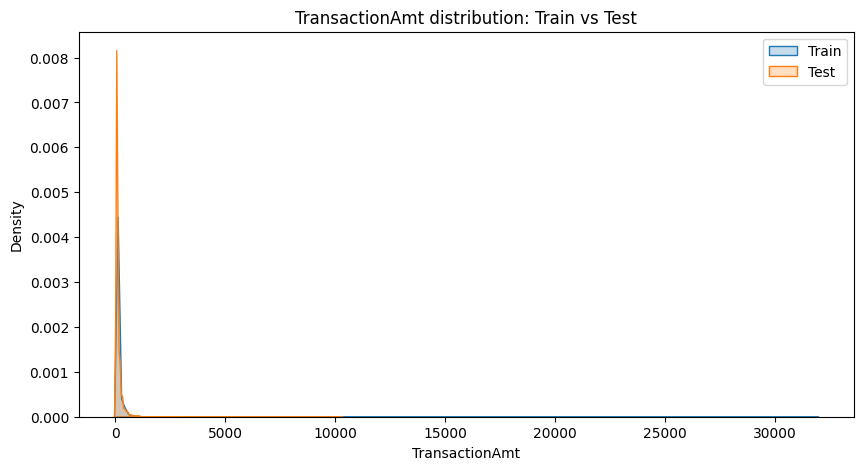

In [13]:
compare_train_test(train_full, test_full, 'TransactionAmt')

In [14]:
compare_train_test(train_full, test_full, 'card4')


card4 top categories train vs test:


,Train,Test
card4,,
visa,0.653296,0.664970
mastercard,0.321271,0.314074
american express,0.014140,0.015252
discover,0.011293,0.005705


In [15]:
compare_train_test(train_full, test_full, 'DeviceType')


DeviceType top categories train vs test:


,Train,Test
DeviceType,,
desktop,0.604822,0.543361
mobile,0.395178,0.456639


In [16]:
compare_train_test(train_full, test_full, 'P_emaildomain')


P_emaildomain top categories train vs test:


,Train,Test
P_emaildomain,,
gmail.com,0.460315,0.474168
yahoo.com,0.203462,0.187086
hotmail.com,0.091214,0.092341
anonymous.com,0.074580,0.077861
aol.com,0.057025,0.054967
comcast.net,0.015901,0.015054
icloud.com,0.012633,0.013826
outlook.com,0.010272,0.011058
msn.com,0.008249,0.007744


# Step 11: 📝 EDA Summary

---

## 📊 Dataset Overview
- **Train:** 590,540 rows × 394 cols (includes `isFraud` target).  
- **Test:** 506,691 rows × 393 cols (no target).  
- After merging identity data → **train = 434 cols, test = 433 cols**.  

---

## 🎯 Target Variable
- Fraud cases: **20,663 (3.5%)**  
- Non-fraud cases: **569,877 (96.5%)**  
- ⚠️ Strong imbalance → need stratified CV, use ROC-AUC / PR-AUC instead of accuracy.

---

## 🔍 Missing Values & Data Types
- Some features (D & V series, identity) have **80–93% missing**.  
- Missingness itself may be predictive (fraudsters often fail to provide full info).  
- Mix of numerical (376), categorical (14), and ID-like features.  

---

## 🔢 Numerical Features
- `TransactionAmt`: highly skewed; fraud often at low-mid values.  
- `TransactionDT`: monotonic, fraud occurs in bursts.  
- Top correlated with fraud: **V257, V246, V244, V242** (~0.35–0.39).  
- V-series = **highly redundant** (multicollinearity). Tree models or PCA needed.  

---

## 🏷️ Categorical Features
- `card4`: Visa & MasterCard dominate; fraud patterns differ.  
- `card6`: Debit vs Credit shows different fraud behavior.  
- `ProductCD`: product categories affect fraud risk.  
- `P_emaildomain`: free domains dominate (gmail, yahoo). Rare domains can be risky.  

---

## 💻 Identity Features
- **DeviceType**: Mobile fraud rate = **10.1%**, Desktop = 6.5%.  
- **DeviceInfo**: rare/older devices show >10% fraud.  
- **OS (id_30)**: outdated versions are riskier.  
- **Browser (id_31)**: “generic” browsers very fraud-prone (>15%).  
- **Resolution (id_33)**: unusual screen sizes strongly linked to fraud.  

---

## 🔗 Cross-Feature Interactions
- Certain **card × device** and **product × OS** combos spike fraud.  
- Reports saved in `/artifacts/` as CSV for future feature engineering.  

---

## 🔄 Train vs Test Check
- Fixed naming mismatch (`id-xx` → `id_xx`).  
- Only difference: train has `isFraud`.  
- Distributions are largely stable:  
  - **TransactionAmt:** aligned.  
  - **card4:** aligned.  
  - **DeviceType:** test has more mobile users.  
  - **P_emaildomain:** mostly stable, Yahoo slightly down.  

---

## ✅ Key Takeaways for Next Phase
- **Severe imbalance** → use stratified folds, threshold tuning.  
- **High missingness** → impute carefully; missingness itself may carry signal.  
- **V-features** → high correlation but redundant → let tree models/PCA handle.  
- **Identity features** → powerful, need categorical encoding.  
- **Cross features** → useful to engineer interaction variables.  
- **No leakage** → safe to proceed to preprocessing.

---

📌 **Next Notebook:** `03_preprocessing.ipynb` → feature cleaning, encoding, and preparation for modeling.
